# Langevin Dynamics - Use the Force

## Goals:

* Familiarize yourself with a typical molecular many-body problem
* Study the concept of pairwise forces and Lennard-Jones potential
* Run many-particle molecular dynamics simulations
* Visualize the results

Let's continue our light-speed travel toward the world of molecular modeling.  In the pre-class assignment we used Langevin dynamics to model a single particle floating around in space.  We are going to transform this into a biomolecular simulation, gradually...

***


## NOTE: we will modify our finite-difference scheme and it will be slightly different from the one used in the pre-class assignment!

In this activity we will introduce the determenistic part of the force, resulting from some inter-particle interaction potential, i.e. we will introduce a non-zero potential energy $U(\overrightarrow{x})$. In this case, we also need to be careful with the random force.

In the continuum Langevin equation we introduce the random force as a continuous Gaussian random process with zero-mean and unit variance:

\begin{eqnarray}
&&\langle R(t)\rangle = 0,\nonumber\\
&&\langle R(t)R(t')\rangle = \delta(t-t'),\nonumber
\end{eqnarray}
where $\delta(t-t')$ is the Dirac delta-function.

We need to introduce a finite-difference scheme where the random force is a discrete process, since the minimal time interval is now $\Delta t$. Going from a continuous to discrete stochastic process is a subtle subject, and we will not discuss it in detail here. Without derivation we will use the following result: if the random force is discrete over time interval $\Delta t$, then its variance is $1/\Delta t$. In other words, for $R(t)$ in our finite difference scheme we need to use

\begin{eqnarray}
&&\langle R(t)R(t')\rangle = \frac{1}{\Delta t}\delta_{tt'},\nonumber
\end{eqnarray}
where $\delta_{tt'}$ is the Kronecker delta, a "discrete" version of the Dirac delta-function. From the above equation we see that each $R(t)$ acquires an extra factor $1/\sqrt{\Delta t}$. We need to correct our finite-difference formula to account for that.

Our two time evolution equations (with the correction described above) are:

\begin{equation} \overrightarrow{x}(t+\Delta t) \approx \overrightarrow{x}(t) + \overrightarrow{v}(t) \Delta t \end{equation}

\begin{equation} \overrightarrow{v}(t+\Delta t) \approx \overrightarrow{v}(t) + \Delta t \left(- \frac{1}{m}\nabla U(\overrightarrow{x}) - \gamma \overrightarrow{v} + \sqrt{\frac{2 \gamma k_B T}{m\Delta t} } \overrightarrow{R}(t) \right) \end{equation}

That term that we were ignoring ($\nabla U(\overrightarrow{x})$), is the key.  $U(\overrightarrow{x})$ is the ***potential energy*** of the system as a function of the spatial coordinates of the system (denoted by $\overrightarrow{x}$). The last term in the second equation, involving $R(t)$, has now correct factor of $\Delta t$ in the denominator.

***We are going to take advantage of two things here***.  First, the vector $\overrightarrow{x}$ can denote the position not just of one particle, but of many different particles.  Say we have $10$ particles in our $2$-dimensional system: $\overrightarrow{x}$ would be a vector with $20$ elements, and $\overrightarrow{v}$ would have $20$ elements as well.  

Secondly, the function $U$ can be ***anything we want***!  We can encode attractive interactions, repulsive, or some combination of those.

Let's get started!
***

## 1) Don't tread on me:  multiple particles with size exclusion
If we start adding more particles, we need to make sure they don't overlap.  If you want to get all physics-y about it, you could read up on the [Pauli exclusion principle](https://en.wikipedia.org/wiki/Pauli_exclusion_principle), and [Van der Waals radii](https://en.wikipedia.org/wiki/Van_der_Waals_radius).  But today we can just imagine that these are billiard balls (or since we're still in 2D, disks on an air hockey table).

To prevent particles (with a certain radius, $r_0/2$) from overlapping, we need a potential energy curve that looks like this:

In [1]:
# import the packages we need in one place
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

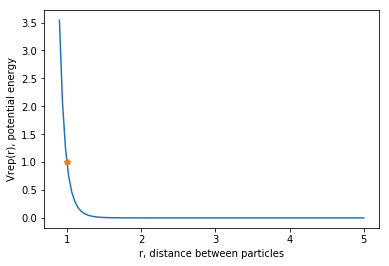

In [29]:
# parameters of the potential
A = 1
r0 = 1

def repel(r):
    Vrep = A*(r0/r)**12
    return Vrep

r = np.linspace(0.9,5,100)

plt.xlabel('r, distance between particles')
plt.ylabel('Vrep(r), potential energy')
plt.plot(r,repel(r))
plt.plot(1,r0,'p')  # shows the particle radius
plt.show()

OK, but remember we don't need the potential, but the ***gradient of the potential***, which is math-speak for the derivative with respect to all of the spatial components.  Let's walk through this:

\begin{equation} V_{rep}(r) = A\left(\frac{r_0}{r}\right)^{12} \end{equation}

\begin{equation} \frac{dV_{rep}(r)}{dr} = -12A\frac{r_0^{12}}{r^{13}} \end{equation}

Almost there.  Remember what our spatial coordinates are, they are our $x$ and $y$ positions for each particle.  So what we *really* need is $dV_{rep}/dx_i$ and $dV_{rep}/dy_i$ (where $i$ denotes the $i$-th particle).  To get those we remember that the distance between two particles $r_{ij} = \sqrt{(x_i-x_j)^2 + (y_i-y_j)^2}$, and use the chain rule:

\begin{equation} \frac{dV_{rep}}{dx_i} = \frac{dV_{rep}}{dr}\frac{dr}{dx_i} = -12A\frac{r_0^{12}}{r^{13}}\left(\frac{1}{2}\frac{1}{\sqrt{(x_i-x_j)^2 + (y_i-y_j)^2}}2(x_i-x_j)\right) = -12A\frac{r_0^{12}}{r^{14}}(x_i-x_j) \end{equation}

***

Let's make this more formal.  Imagine a system with $N$ particles of radius $r_0/2$, that are all excluded from sharing volume with each other.  The total potential energy of the system is:

\begin{equation} V(\overrightarrow{x}) = \sum_{i=1}^{N-1} \sum_{j=i+1}^N V_{rep}(r_{ij})\end{equation}

and the derivative of all of this with respect to a particular spatial coordinate:

\begin{equation} \frac{dV(\overrightarrow{x})}{dx_i} = \sum_{j \ne i} \frac{dV_{rep}(r_{ij})}{dx_i} = \sum_{j \ne i} -12A\frac{r_0^{12}}{r_{ij}^{14}}(x_i-x_j) \end{equation}

We are pretty much ready to go!  ***Although let's make one little tweak for the sake of performance***.  As you can see in the plot above, there isn't going to be much of a force between two particles that are far away.  So let's only compute the force if $r_{ij}$ is less than a cutoff, say, $2r_0$.


---
Starting with our code from pre-class, with a properly modified finite-difference discretization of the random force, let's run a trajectory with $20$ particles. First we collect all the functions that we need for the simulation in the block below.

Study the provided code to understand what exactly it is doing. Here is the sketch of the main components. The function `updatepos()` updates the positions based on instantaneous velocities. This is an easy operation which scales with the number of particles `npart`. The function `updatevel()` updates the velocities. For this purpose it needs to evaluate the pair-wise forces between particles and also the random forces. The former are computed by the `dvdx()` function and the latter by the `rfunc()` function. There is one random force per particle, so this operation also scales with `npart`. The evaluation of pair-wise forces is more costly, since we need to calculate the force between all possible pairs. This operation scales as `npart`$^2$. This is typical for molecular dynamics simulations that the most costly part is the evaluation of the forces. To prepare for the force calculation in `dvdx()`, at every time step we call the function `getdistancematrix()` that evaluates distances between all particles and returns them as a matrix `dmat`. Its size is `npart`$\times$`npart`. The `peri_min()` function calculates the distance between particles taking into account the periodic boundary condition, since minimal distance between two particles may be through the boundary. And the `pbc_check()` function enforces the periodic boundary conditions on positions. Also, when we generate a random initial configuration, we need to make sure that particles are not too close to each other, otherwise it may result in too large forces rendering our simulation unstable. For this purpose we use the `setup_positions()` function.

In [30]:
# collect all the auxiliary functions we need in one block

# update particle positions
def updatepos(xold,vold):
    # returns the new positions, using the old positions and the old velocities
    xnew = xold + vold*dt
    return xnew

# update i-th particle velocity
def updatevel(i,whole_x,whole_v,dmat):
    # returns the new velocities, given the old acceleration
    # which is the sum of the external forces, a drag term, and a random force
    vnew = whole_v[i] + dt*(-dvdx(i,whole_x,dmat)/m - gamma*whole_v[i] + pref*rfunc())
    return vnew

# total force on the i-th particle
def dvdx(i,whole_x,dmat):
    # uses the whole position matrix and returns the force vector on particle i
    f0 = np.array([0,0],dtype='double')
    for j in range(npart):
        if j != i:
            if dmat[i][j] < 2*rcutsq:
                d14 = dmat[i][j]**7
                tmp = -12.0*A*r012/d14
                f0[0] += tmp*peri_min(whole_x[i][0],whole_x[j][0])
                f0[1] += tmp*peri_min(whole_x[i][1],whole_x[j][1])
    return f0

# random force drawn from Gaussian distribution
def rfunc():
    # return a vector with components chosen from a Gaussian distribution
    r = np.random.normal(size=2)
    return r

# calculate minimal distance between particles taking into
# account periodic boundary conditions
# (i.e. particles may be closer through the boundary)
def peri_min(x1,x2):
    d1 = x1-x2
    d2 = x1-x2-L
    d3 = x1-x2+L
    if abs(d1) < abs(d2):
        if abs(d1) < abs(d3):
            return d1
        else:
            return d3
    elif abs(d2) < abs(d3):
        return d2
    else:
        return d3

# calculate all interparticle distance as a matrix
def getdistancematrix(x):
    # returns a matrix of particle-particle distances
    dmat = np.zeros((npart,npart))
    for i in range(npart-1):
        for j in range(i+1,npart):
            d = (peri_min(x[i][0],x[j][0]))**2 + (peri_min(x[i][1],x[j][1]))**2
            dmat[i][j]=d
            dmat[j][i]=d
    return dmat

# apply periodic boundary conditions
def pbc_check (xold):
    # check the first component:  xold[0]
    if xold[0] < 0:
        xold[0] += L
    if xold[0] > L:
        xold[0] -= L

    # check the second component:  xold[1]
    if xold[1] < 0:
        xold[1] += L
    if xold[1] > L:
        xold[1] -= L
    return xold

# set initial particle positions
# (check for possible overlaps and retry)
def setup_positions():
    x0 = np.zeros((npart,2))
    for i in range(npart):
        allgood = False
        while (not allgood):
            x0[i] = np.random.random(size=2)

            # check for clashes
            allgood = True
            if i > 0:
                for j in range(i):
                    d = peri_min(x0[i][0],x0[j][0])**2 + peri_min(x0[i][1],x0[j][1])**2
                    if d < rcutsq:
                        allgood = False
    return x0

Next, we define all the constants and run parameters that we need and run the simulation loop.

In [31]:
# define our constants
m = 0.5      # the mass of our particles
kT = 1.0     # thermal energy
gamma = 5.0  # friction coefficient
dt = 0.00002 # time step
N = 10000    # number of time steps
npart = 20   # number of particles
r0 = 0.10
L = 1.0
r06 = r0**6
r012 = r0**12
rcutsq = 2*r0**2
A = 1.0
B = 1.0

save_int = 100  # how often to save the position

pref = (2*gamma*kT/m/dt)**(0.5)   # prefactor for random force
                                  # (only compute once and store)


# ----------------------------------
#    simulation starts here
# ----------------------------------

# this will record our positions as a function of time
traj = np.zeros((int(N/save_int),npart,2))

x0 = setup_positions()   # initial position
v0 = np.random.normal(loc=0,scale=(kT/m)**0.5,size=(npart,2))  # initial velocity

x = x0
v = v0

for step in range(N):
    
    dmat = getdistancematrix(x)  # compute the distance matrix only once per time step
    
    # loop over particles
    for i in range(npart):
        xn = updatepos(x[i],v[i])
        vn = updatevel(i,x,v,dmat)   # let it know you are working on the ith particle
        x[i],v[i] = pbc_check(xn),vn
        
    if step % save_int == 0:
        frame = int(step/save_int)
        traj[frame] = x

        
    if (step+1)*10 % N == 0:
        pct = int((step+1)*10/N)*10
        print ("%d percent completed" % pct)

10 percent completed
20 percent completed
30 percent completed
40 percent completed
50 percent completed
60 percent completed
70 percent completed
80 percent completed
90 percent completed
100 percent completed


Visualize the particle trajectories, and see if you can spot collisions (i.e. when particles get to distances on the order of $r_0$ from each other and almost reverse their directions of travel).

/Users/fangchunliang/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


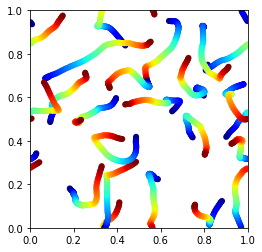

In [32]:
# show all particle trajectories

% matplotlib inline
import matplotlib.pyplot as plt

# set the size of the plot
plt.xlim(0,L)
plt.ylim(0,L)
# set the plot aspect ratio to square
plt.axes().set_aspect('equal')

color=np.array(range(0,int(N/save_int)),dtype='float')
for i in range(npart):
    plt.scatter(traj[:,i,0],traj[:,i,1],c=color,edgecolors='none',cmap='jet')
plt.show()

We can also plot particles as finite disks at a given time step (frame).

/Users/fangchunliang/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


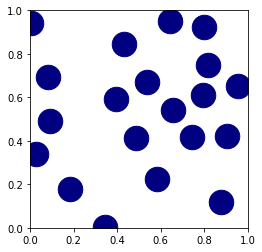

In [33]:
# show a single frame

# set the size of the plot
plt.xlim(0,L)
plt.ylim(0,L)
# set the plot aspect ratio to square
plt.axes().set_aspect('equal')

color=np.array(range(0,int(N/save_int)),dtype='float')
frame = 1
for i in range(npart):
    plt.scatter(traj[frame,i,0],traj[frame,i,1],s=600,c=color[frame],cmap='jet')
plt.show()

***
## 2) Let's get packing

Another potential form that is used often in molecular simulations is called a [Lennard-Jones potential](https://en.wikipedia.org/wiki/Lennard-Jones_potential).  This has a similar $1/r^{12}$ repulsive term, with another attractive $1/r^6$ term added on:

\begin{equation} V_{LJ}(r) = A\left(\frac{r_0}{r}\right)^{12} - B\left(\frac{r_0}{r}\right)^6 \end{equation}

Which looks like this:

/Users/fangchunliang/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:754: ComplexWarning: Casting complex values to real discards the imaginary part
  tmp_a_data = tmp_a.astype(float)
/Users/fangchunliang/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:760: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = tmp_a.astype(np.intp)
/Users/fangchunliang/anaconda3/lib/python3.6/site-packages/matplotlib/transforms.py:814: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/Users/fangchunliang/anaconda3/lib/python3.6/site-packages/matplotlib/transforms.py:2037: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


(array([  869.,  1386.,  1561.,  2445.,  2642.,  3247.,  3258.,  2095.,
         1097.,   400.]),
 array([ 0.09165950+0.j,  0.15204425+0.j,  0.21242900+0.j,  0.27281375+0.j,
         0.33319850+0.j,  0.39358324+0.j,  0.45396799+0.j,  0.51435274+0.j,
         0.57473749+0.j,  0.63512224+0.j,  0.69550699+0.j]),
 <a list of 10 Patch objects>)

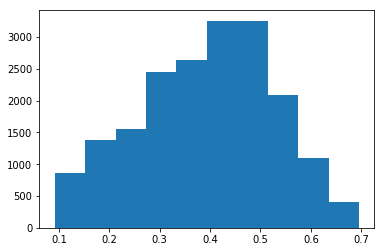

In [35]:
import cmath as math
d_list=[]
for step in range (int(N/100)):
    for i in range (npart-1):
        for j in range(i+1,npart):
            d = math.sqrt(peri_min(traj[step,i,0],traj[step,j,0])**2 + peri_min(traj[step,i,1],traj[step,j,1])**2)
            d_list.append(d)
# add your code here

# plot normalized histogram

# add your code here
plt.hist(d_list)

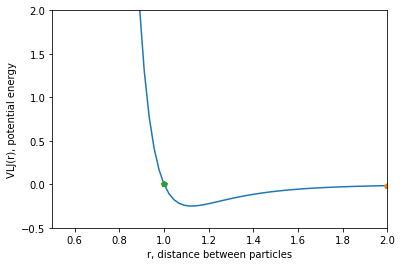

In [14]:
import numpy as np
A = 1.0
B = 1.0
r0 = 1

def LJ(r):
    Vlj = A*(r0/r)**12 - B*(r0/r)**6
    return Vlj

r = np.linspace(0.8,3,100)
rcutsq = 2*r0**2
x=np.sqrt(2*rcutsq)
y=LJ(x)
x2=np.sqrt(0.5*rcutsq)
y2=LJ(x2)
plt.xlabel('r, distance between particles')
plt.ylabel('VLJ(r), potential energy')
plt.xlim(0.5,2.0)
plt.ylim(-0.5,2.0)
plt.plot(r,LJ(r))
plt.plot(x,y,'p')
plt.plot(x2,y2,'p')
plt.plot()
plt.show()

### Q)  What is the derivative of this function with respect to $r$?

\begin{equation} \frac{dV_{rep}(LJ)}{dr} = -12A\frac{r_0^{12}}{r^{13}}+6B\frac{r_0^{6}}{r^{7}} \end{equation}



### Q)  Given the complete potential energy function written below, what is the derivative of this with respect to $x_i$?

\begin{equation} V(\overrightarrow{x}) = \sum_{i=1}^{N-1} \sum_{j=i+1}^N V_{LJ}(r_{ij})\end{equation}

\begin{equation} \frac{dV(\overrightarrow{x})}{dx_i} = \sum_{j \ne i} \frac{dV_{rep}(r_{ij})}{dx_i} = \sum_{j \ne i} -12A\frac{r_0^{12}}{r_{ij}^{14}}(x_i-x_j)+6B\frac{r_0^{6}}{r_{ij}^{8}}(x_i-x_j) \end{equation}

### Q) Modify the `dvdx()` function above to include this new potential.

In [37]:
# modified force function for Lennard-Jones potential
def dvdx(i,whole_x,dmat):
    # uses the whole position matrix and returns the force vector on particle i
    f0 = np.array([0,0],dtype='double')
    # add your code here
    for j in range(npart):
        if j != i:
            if dmat[i][j] < 2*rcutsq:
                d14 = dmat[i][j]**7
                tmp = -12.0*A*r012/d14
                d8 = dmat[i][j]**4
                tmp1 = 6*B*r06/d8
                f0[0] += (tmp+tmp1)*peri_min(whole_x[i][0],whole_x[j][0])
                f0[1] += (tmp+tmp1)*peri_min(whole_x[i][1],whole_x[j][1])
    return f0

### Q) Run a trajectory using the parameters below.

In [38]:
# define our constants
m = 0.5      # the mass of our particles
kT = 1.0     # thermal energy
gamma = 5.0  # friction coefficient
dt = 0.00002 # time step
N = 10000    # number of time steps
npart = 20   # number of particles
r0 = 0.10
L = 1.0
r06 = r0**6
r012 = r0**12
rcutsq = 2*r0**2
A = 1.0
B = 1.0

pref = (2*gamma*kT/m/dt)**(0.5) # prefactor for random force
                                # (only compute once and store)
save_int = 100
    
# ----------------------------------
#    simulation starts here
# ----------------------------------

# add your code here
# this will record our positions as a function of time
traj = np.zeros((int(N/save_int),npart,2))

x0 = setup_positions()   # initial position
v0 = np.random.normal(loc=0,scale=(kT/m)**0.5,size=(npart,2))  # initial velocity

x = x0
v = v0

for step in range(N):
    
    dmat = getdistancematrix(x)  # compute the distance matrix only once per time step
    
    # loop over particles
    for i in range(npart):
        xn = updatepos(x[i],v[i])
        vn = updatevel(i,x,v,dmat)   # let it know you are working on the ith particle
        x[i],v[i] = pbc_check(xn),vn
        
    if step % save_int == 0:
        frame = int(step/save_int)
        traj[frame] = x

        
    if (step+1)*10 % N == 0:
        pct = int((step+1)*10/N)*10
        print ("%d percent completed" % pct)


10 percent completed
20 percent completed
30 percent completed
40 percent completed
50 percent completed
60 percent completed
70 percent completed
80 percent completed
90 percent completed
100 percent completed


/Users/fangchunliang/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


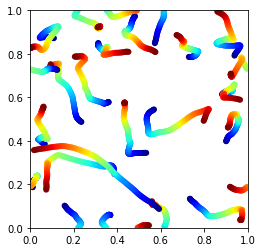

In [39]:
# show all particle trajectories

# add your code here
% matplotlib inline
import matplotlib.pyplot as plt

# set the size of the plot
plt.xlim(0,L)
plt.ylim(0,L)
# set the plot aspect ratio to square
plt.axes().set_aspect('equal')

color=np.array(range(0,int(N/save_int)),dtype='float')
for i in range(npart):
    plt.scatter(traj[:,i,0],traj[:,i,1],c=color,edgecolors='none',cmap='jet')
plt.show()

/Users/fangchunliang/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


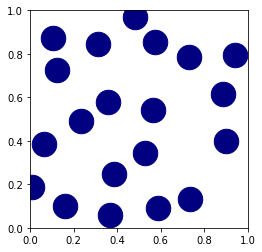

In [40]:
# show a single frame

# add your code here
# set the size of the plot
plt.xlim(0,L)
plt.ylim(0,L)
# set the plot aspect ratio to square
plt.axes().set_aspect('equal')

color=np.array(range(0,int(N/save_int)),dtype='float')
frame = 1
for i in range(npart):
    plt.scatter(traj[frame,i,0],traj[frame,i,1],s=600,c=color[frame],cmap='jet')
plt.show()

### Q)  Using the data stored in the `traj` array, calculate the probability of being a certain distance `r` away from another particle in this simulation. (This is, in fact, a [Radial distribution function](https://en.wikipedia.org/wiki/Radial_distribution_function).)
Hint:  first make a list of distances, then make a histogram using `plt.hist`. Use the `peri_min()` function defined above to calculate the distance.

(array([  895.,  1324.,  1936.,  2246.,  2753.,  3209.,  3507.,  1815.,
         1009.,   306.]),
 array([ 0.08576725,  0.1475656 ,  0.20936395,  0.2711623 ,  0.33296065,
         0.394759  ,  0.45655735,  0.5183557 ,  0.58015405,  0.6419524 ,
         0.70375075]),
 <a list of 10 Patch objects>)

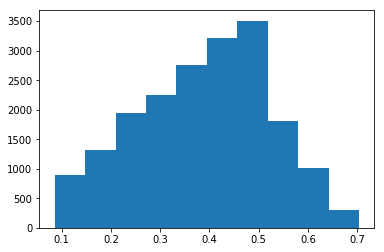

In [43]:
# initialize distance list
dist_list=[]

# loop over time frames
for step in range (N):
    for i in range (npart-1):
        for j in range(i+1,npart):
            if step % save_int == 0:
                frame = int(step/save_int)
                d = np.sqrt(peri_min(traj[frame,i,0],traj[frame,j,0])**2 + peri_min(traj[frame,i,1],traj[frame,j,1])**2)
                dist_list.append(d)
# add your code here

# plot normalized histogram

# add your code here
plt.hist(dist_list)

/Users/fangchunliang/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:754: ComplexWarning: Casting complex values to real discards the imaginary part
  tmp_a_data = tmp_a.astype(float)
/Users/fangchunliang/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:760: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = tmp_a.astype(np.intp)
/Users/fangchunliang/anaconda3/lib/python3.6/site-packages/matplotlib/transforms.py:814: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/Users/fangchunliang/anaconda3/lib/python3.6/site-packages/matplotlib/transforms.py:2037: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


(array([  895.,  1324.,  1936.,  2246.,  2753.,  3209.,  3507.,  1815.,
         1009.,   306.]),
 array([ 0.08576725+0.j,  0.14756560+0.j,  0.20936395+0.j,  0.27116230+0.j,
         0.33296065+0.j,  0.39475900+0.j,  0.45655735+0.j,  0.51835570+0.j,
         0.58015405+0.j,  0.64195240+0.j,  0.70375075+0.j]),
 <a list of 10 Patch objects>)

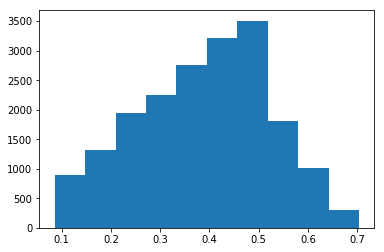

In [42]:
import cmath as math
d_list=[]
for step in range (int(N/100)):
    for i in range (npart-1):
        for j in range(i+1,npart):
            d = math.sqrt(peri_min(traj[step,i,0],traj[step,j,0])**2 + peri_min(traj[step,i,1],traj[step,j,1])**2)
            d_list.append(d)
# add your code here

# plot normalized histogram

# add your code here
plt.hist(d_list)